In [37]:

import os
import sys
import pandas as pd
import geopandas as gpd
import numpy as np

import matplotlib.pyplot as plt

from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    precision_score,
    recall_score,
    precision_recall_curve,
    ConfusionMatrixDisplay,
    roc_curve,
    RocCurveDisplay,
    auc,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import RandomizedSearchCV, train_test_split

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
from scipy.stats import uniform, randint

In [38]:
data = pd.read_csv(
    "/capstone/wildfire_prep/data/PUZZLE_PIECES/assembled_puzzle.csv"
).drop(columns="basemap_id")

print(data.shape)
print(data.columns)
data.head()

(67580, 4005)
Index(['inspection_id', 'X_0', 'X_1', 'X_2', 'X_3', 'X_4', 'X_5', 'X_6', 'X_7',
       'X_8',
       ...
       'X_3994', 'X_3995', 'X_3996', 'X_3997', 'X_3998', 'X_3999',
       'maj_landcover_code_x', 'maj_landcover_code_y', 'status',
       'structure_code'],
      dtype='object', length=4005)


,inspection_id,X_0,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,...,X_3994,X_3995,X_3996,X_3997,X_3998,X_3999,maj_landcover_code_x,maj_landcover_code_y,status,structure_code
0,1,0.054892,0.0,0.015004,0.0,0.238797,0.000466,0.0,0.055266,0.005605,...,0.052267,2.742807,1.274291,1.905394,4.261047,2.500061,304.0,557,0,100
1,2,0.024470,0.0,0.003108,0.0,0.129467,0.000687,0.0,0.034108,0.012225,...,0.232065,2.272318,1.205103,1.661454,3.457836,2.098205,304.0,304,0,101
2,3,0.271383,0.0,0.126712,0.0,0.976787,0.043854,0.0,0.528058,0.124882,...,0.000000,3.815154,1.246298,2.504779,6.486201,3.454411,303.0,303,0,101
3,4,0.097084,0.0,0.037654,0.0,0.549639,0.001046,0.0,0.240636,0.017580,...,0.016924,3.105121,1.228030,2.112541,5.209030,2.868551,39.0,304,0,100
4,5,0.041986,0.0,0.008531,0.0,0.253195,0.001353,0.0,0.036694,0.002605,...,0.040597,2.683573,1.311833,1.853227,4.251881,2.500635,304.0,304,0,101


## Downsample Majority Class Approach

In [39]:
# # Outdated Downsampling Approach Cell

# # Pull out majority/minority from data
# compliant = data[data.status == 0]
# non_compliant = data[data.status == 1]

# # Downsample majority to be 3x minority's size
# n_majority_desired = len(non_compliant) * 3
# compliant_down = compliant.sample(n=n_majority_desired, random_state=42)

# # Reassemble and shuffle
# data_downsampled_maj = (
#     pd.concat([non_compliant, compliant_down])
#     .sample(frac=1, random_state=42)
#     .reset_index(drop=True)
# )

# # Split back into X_train and y_train, downsampled
# X = data_downsampled_maj.drop("status", axis=1)
# y = data_downsampled_maj["status"]

# downsample_data_ids = X.inspection_id

# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, stratify=y, random_state=42
# )

# # Dropping inspection_id, to prevent overfitting to this ID.
# X_train = X_train.drop(columns="inspection_id")
# # Do the same for X_test, so that the datasets align
# X_test = X_test.drop(columns="inspection_id")

# # Balance check
# print("Shapes:")
# print("  X_train:", X_train.shape)
# print("  y_train:", y_train.shape)
# print("  X_test: ", X_test.shape)
# print("  y_test: ", y_test.shape)

# print("\nTrain distribution after downsampling:")
# print(y_train.value_counts(normalize=True))

# X_train


In [40]:
X = data.drop("status", axis=1)
y = data["status"]

upsample_data_ids = X.inspection_id

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

train = pd.concat([X_train, y_train], axis=1)

majority = train[train.status == 0]
minority = train[train.status == 1]

n_majority_desired = len(minority) * 3
majority_downsampled = majority.sample(
    n=n_majority_desired, replace=False, random_state=42
)

train_balanced = (
    pd.concat([majority_downsampled, minority])
    .sample(frac=1, random_state=42)
    .reset_index(drop=True)
)

X_train = train_balanced.drop("status", axis=1).drop(columns="inspection_id")
y_train = train_balanced["status"]

X_test = X_test.drop(columns="inspection_id")

print(f"Shape of compliant:", majority.shape)
print(f"Shape of non-compliant:", minority.shape)

print(f"N_minority desired:", int(len(majority) * 3))

print("Shapes:")
print(" Downsampled X_train:", X_train.shape)
print(" Downsampled y_train:", y_train.shape)
print(" Downsampled X_test: ", X_test.shape)
print(" Downsampled y_test: ", y_test.shape)

print("\nTrain distribution after downsampling:")
print(y_train.value_counts(normalize=True))

X_train


Shape of compliant: (53730, 4005)
Shape of non-compliant: (334, 4005)
N_minority desired: 161190
Shapes:
 Downsampled X_train: (1336, 4003)
 Downsampled y_train: (1336,)
 Downsampled X_test:  (13516, 4003)
 Downsampled y_test:  (13516,)

Train distribution after downsampling:
status
0    0.75
1    0.25
Name: proportion, dtype: float64


,X_0,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,...,X_3993,X_3994,X_3995,X_3996,X_3997,X_3998,X_3999,maj_landcover_code_x,maj_landcover_code_y,structure_code
0,0.980615,0.0,0.498733,0.001490,1.925463,0.219529,0.0,0.982447,0.366697,0.063637,...,1.917105,0.009606,5.100002,1.500538,3.119550,8.773360,4.585543,303.0,582,102
1,0.595608,0.0,0.368074,0.017719,1.460289,0.205838,0.0,0.779316,0.339393,0.055420,...,1.927565,0.051871,4.595747,1.406411,2.920641,7.778569,4.184819,581.0,304,102
2,0.166876,0.0,0.098818,0.000000,0.838690,0.024531,0.0,0.378152,0.045195,0.000267,...,1.666842,0.000407,3.668862,1.303262,2.445058,6.129449,3.333632,303.0,582,102
3,0.251729,0.0,0.217023,0.000000,0.943251,0.136851,0.0,0.667194,0.302191,0.008528,...,1.847715,0.039587,3.930247,1.121837,2.670616,6.626384,3.462433,556.0,556,101
4,0.517334,0.0,0.193630,0.000000,1.533866,0.117757,0.0,0.760257,0.226459,0.012133,...,1.995993,0.000000,4.638525,1.332656,2.960548,7.932229,4.292342,582.0,582,102
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1331,0.214842,0.0,0.084297,0.003410,0.632061,0.075151,0.0,0.250915,0.165691,0.036268,...,1.610542,0.224676,3.254421,1.229582,2.219869,5.227838,3.010955,581.0,304,102
1332,0.659951,0.0,0.438005,0.000000,1.623533,0.192162,0.0,0.806604,0.205872,0.074531,...,1.821152,0.000802,4.668066,1.557677,2.876851,8.065570,4.291951,581.0,303,100
1333,0.346324,0.0,0.281637,0.000000,1.226964,0.136658,0.0,0.847138,0.388027,0.016122,...,1.910953,0.000000,4.322846,1.148208,2.836028,7.401264,3.821792,556.0,581,104
1334,0.870053,0.0,0.559589,0.002623,2.033172,0.348026,0.0,1.069538,0.424388,0.119261,...,2.059601,0.002596,5.287234,1.534886,3.268098,9.213343,4.864600,582.0,303,102


## Upsample Minority Class Approach


In [41]:
# # Outdated Upsampling Approach Cell

# # Pull out majority/minority from data
# compliant = data[data.status == 0]
# non_compliant = data[data.status == 1]

# # Upsample minority to match majority’s size
# n_minority_desired = int(len(compliant) / 3)

# non_compliant_upsampled = non_compliant.sample(
#     n=n_minority_desired, replace=True, random_state=42
# )

# # Reassemble and shuffle train set
# data_upsampled_min = (
#     pd.concat([compliant, non_compliant_upsampled])
#     .sample(frac=1, random_state=42)
#     .reset_index(drop=True)
# )

# # Split back into X_train y_train, upsampled
# X = data_upsampled_min.drop("status", axis=1)
# y = data_upsampled_min["status"]

# # Save inspection_ids from the data, in case we need them later
# upsample_data_ids = X.inspection_id

# # split data, as usual. 20% test data split.
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, stratify=y, random_state=42
# )

# # Dropping inspection_id, to prevent overfitting to this ID.
# X_train = X_train.drop(columns="inspection_id")
# # Do the same for X_test, so that the datasets align
# X_test = X_test.drop(columns="inspection_id")

# # Check majority/minority sizes
# print(f"Shape of compliant:", compliant.shape)
# print(f"Shape of non-compliant:", non_compliant.shape)

# print(f"N_minority desired:", int(len(compliant) / 3))
# print(f"Shape of non-compliant upsampled:", non_compliant_upsampled.shape)
# print(f"Shape of upsampled training data:", data_upsampled_min.shape)

# print("Shapes:")
# print(" Upsampled X_train:", X_train.shape)
# print(" Upsampled y_train:", y_train.shape)
# print(" Upsampled X_test: ", X_test.shape)
# print(" Upsampled y_test: ", y_test.shape)

# print("\nTrain distribution after up-sampling:")
# print(y_train.value_counts(normalize=True))

# X_train


In [42]:
X = data.drop("status", axis=1)
y = data["status"]

# Save inspection_ids from the data, in case we need them later
upsample_data_ids = X.inspection_id

# split data, as usual. 20% test data split.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, stratify=y, random_state=42 # trying 50% test/train split, instead of 20%
)

# Recombine just the train fold
train = pd.concat([X_train, y_train], axis=1)

# Up-sample the minority inside train
majority = train[train.status == 0]
minority = train[train.status == 1]
n_min = int(len(majority) / 3)

minority_upsampled = minority.sample(n=n_min, replace=True, random_state=42)

train_balanced = (
    pd.concat([majority, minority_upsampled])
    .sample(frac=1, random_state=42)
    .reset_index(drop=True)
)

X_train = train_balanced.drop("status", axis=1).drop(columns="inspection_id")
y_train = train_balanced["status"]
X_test = X_test.drop(columns="inspection_id")

# Check majority/minority sizes
print(f"Shape of compliant:", majority.shape)
print(f"Shape of non-compliant:", minority.shape)

print(f"N_minority desired:", n_min)

print("Shapes:")
print(" Upsampled X_train:", X_train.shape)
print(" Upsampled y_train:", y_train.shape)
print(" Upsampled X_test: ", X_test.shape)
print(" Upsampled y_test: ", y_test.shape)

print("\nTrain distribution after upsampling:")
print(y_train.value_counts(normalize=True))

X_train


Shape of compliant: (33581, 4005)
Shape of non-compliant: (209, 4005)
N_minority desired: 11193
Shapes:
 Upsampled X_train: (44774, 4003)
 Upsampled y_train: (44774,)
 Upsampled X_test:  (33790, 4003)
 Upsampled y_test:  (33790,)

Train distribution after upsampling:
status
0    0.750011
1    0.249989
Name: proportion, dtype: float64


,X_0,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,...,X_3993,X_3994,X_3995,X_3996,X_3997,X_3998,X_3999,maj_landcover_code_x,maj_landcover_code_y,structure_code
0,1.089325,0.000000,0.566536,0.000000,2.070685,0.211082,0.0,0.951382,0.182282,0.033155,...,1.814601,0.000000,5.143792,1.706138,3.042337,8.937907,4.709523,581.0,581,102
1,0.101388,0.000000,0.059215,0.000000,0.428989,0.044718,0.0,0.116402,0.047413,0.028202,...,1.414111,0.174432,2.771906,1.343175,1.929919,4.452906,2.652895,582.0,582,111
2,0.243038,0.000000,0.171408,0.004276,1.028983,0.156747,0.0,0.619098,0.335078,0.034069,...,1.949691,0.088193,4.052195,1.157674,2.773080,6.825231,3.730448,583.0,583,102
3,0.618041,0.000000,0.275904,0.000000,1.519193,0.075378,0.0,0.615456,0.133954,0.012563,...,1.780553,0.000000,4.503628,1.543105,2.787933,7.652158,4.150620,303.0,556,114
4,0.570410,0.000000,0.355634,0.000000,1.642112,0.189388,0.0,1.004898,0.347450,0.008303,...,2.035604,0.000000,4.824598,1.301486,3.077952,8.382947,4.384881,304.0,581,100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44769,0.348164,0.000000,0.208810,0.000000,1.012982,0.108618,0.0,0.565059,0.190070,0.016111,...,1.703101,0.005996,3.868325,1.272624,2.535156,6.591361,3.496789,582.0,556,101
44770,0.065158,0.000000,0.009460,0.000000,0.375973,0.004422,0.0,0.109608,0.021736,0.000132,...,1.407522,0.022545,2.910840,1.254563,1.979092,4.646752,2.651361,581.0,581,102
44771,0.693833,0.000000,0.346992,0.000000,1.678966,0.077611,0.0,0.719898,0.188245,0.022181,...,1.877190,0.000000,4.782387,1.564004,2.944865,8.105541,4.387254,581.0,581,102
44772,0.231380,0.000000,0.247571,0.000000,1.133837,0.132208,0.0,0.700820,0.116387,0.001577,...,1.792463,0.000000,4.048651,1.291026,2.671610,7.054109,3.706701,582.0,304,101


# XGBoost Classifier

Length of y_pred: 33790
Accuracy: 0.9937259544243859


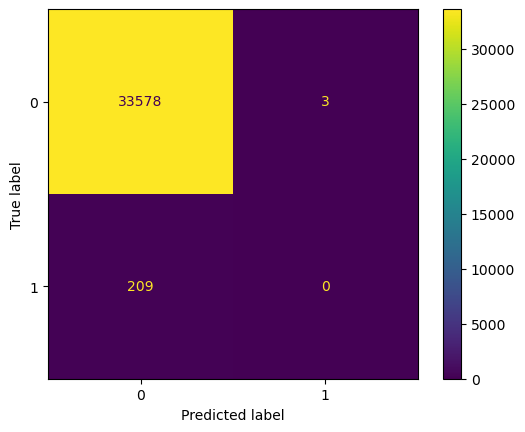

In [44]:
xgb = XGBClassifier(eval_metric="logloss", random_state=42, n_jobs=-1)

xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Length of y_pred:", len(y_pred))
print("Accuracy:", accuracy)

cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();


In [45]:


param_dist_xgb = {
    "max_depth": randint(3, 12),
    "learning_rate": uniform(0.01, 0.3),
    "subsample": uniform(0.6, 0.4),
    "colsample_bytree": uniform(0.6, 0.4),
    "gamma": uniform(0, 5),
}

halving_search_xgb = HalvingRandomSearchCV(
    estimator=xgb,
    param_distributions=param_dist_xgb,
    resource="n_estimators",
    min_resources=20, # Tried with 200
    max_resources=200,  # And with 2000
    factor=3,
    cv=2, # Tried with 3 folds - took 180 minutes and had the same end results
    scoring="precision",
    n_jobs=-1,
    verbose=1,
)

halving_search_xgb.fit(X_train, y_train)
print("Best XGB params:", halving_search_xgb.best_params_)
print("Chosen n_estimators:", halving_search_xgb.best_estimator_.n_estimators)


n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 20
max_resources_: 200
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 10
n_resources: 20
Fitting 2 folds for each of 10 candidates, totalling 20 fits
----------
iter: 1
n_candidates: 4
n_resources: 60
Fitting 2 folds for each of 4 candidates, totalling 8 fits
----------
iter: 2
n_candidates: 2
n_resources: 180
Fitting 2 folds for each of 2 candidates, totalling 4 fits
Best XGB params: {'colsample_bytree': np.float64(0.6127524924162671), 'gamma': np.float64(4.92508774566618), 'learning_rate': np.float64(0.08755414053944016), 'max_depth': 7, 'subsample': np.float64(0.6283903080450219), 'n_estimators': 180}
Chosen n_estimators: 180


In [46]:
best_params = halving_search_xgb.best_params_

best_xgb = XGBClassifier(**best_params, random_state=42, n_jobs=-1, bootstrap=True)

best_xgb.fit(X_train, y_train)

y_pred = best_xgb.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Length of y_pred:", len(y_pred))
print("Accuracy:", accuracy)

y_scores = best_xgb.predict_proba(X_test)[:, 1]

print(best_params)


/Users/ryangreen/.conda/envs/prg/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [23:15:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "bootstrap" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Length of y_pred: 33790
Accuracy: 0.9937555489789879
{'colsample_bytree': np.float64(0.6127524924162671), 'gamma': np.float64(4.92508774566618), 'learning_rate': np.float64(0.08755414053944016), 'max_depth': 7, 'subsample': np.float64(0.6283903080450219), 'n_estimators': 180}


Accuracy: 0.9937555489789879
Precision: 0.0
Recall: 0.0


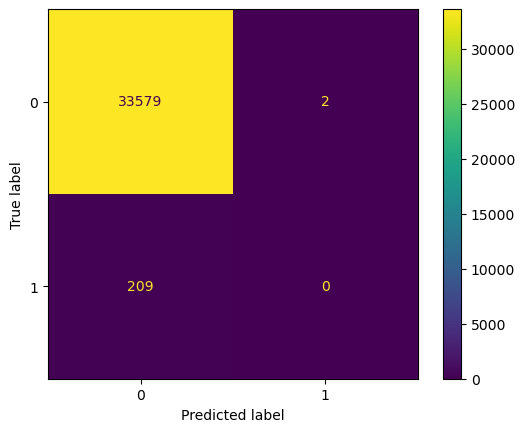

In [47]:
feature_importances = pd.Series(
    best_xgb.feature_importances_, index=X_train.columns
).sort_values(ascending=False)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();


Feature importances:
 X_1112    0.006630
X_3371    0.006026
X_664     0.005603
X_833     0.004860
X_3267    0.004379
dtype: float32


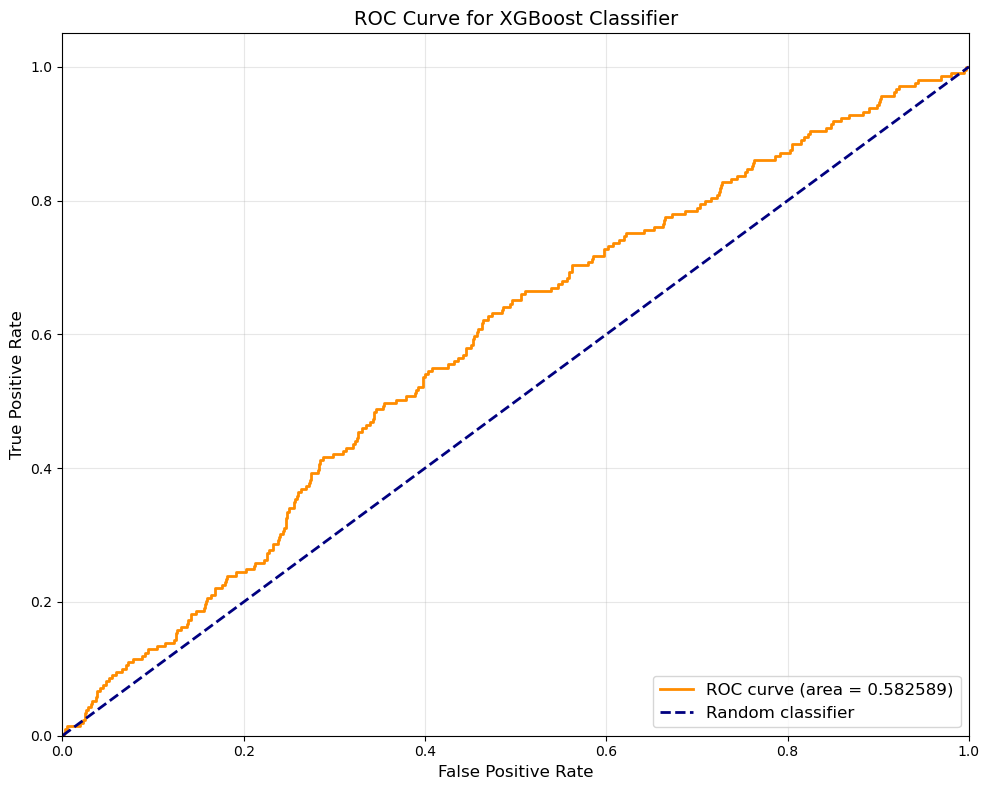

ROC AUC Score: 0.5826


In [48]:
import matplotlib.pyplot as plt

print(f"Feature importances:\n", feature_importances.head())

# Generate the ROC curve
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# Create the plot
plt.figure(figsize=(10, 8))

# Plot ROC curve
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {roc_auc:.6f})")

# Plot baseline
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--", label="Random classifier")

# Style the plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.title("ROC Curve for XGBoost Classifier", fontsize=14)
plt.legend(loc="lower right", fontsize=12)

# Add grid
plt.grid(alpha=0.3)

# Display the plot
plt.tight_layout()
plt.show()

# Print numeric results for reference
print(f"ROC AUC Score: {roc_auc:.4f}")
